In [1]:
%load_ext autoreload
%autoreload 2

import sys
import pandas as pd
from matplotlib import pyplot as plt


sys.path.insert(0, "..") 
from src.data import make_dataset
from src.features import build_features
from src.visualization import visualize

pd.set_option("display.precision", 5)
pd.set_option("display.max.columns", None)
pd.options.display.float_format = '{:6.5f}'.format

import seaborn as sns

Bonds

In dit onderzoek is uitgegaan van een beperkte set bonds. Het is nog onduidelijk of de data van verlopen bonds ook zinvol is voor het onderzoek. Een bond is typisch maar kort in portefeuille waardoor we geen lange tijdreeksen hebben van een bepaalde bond. Mogelijk komt de bond wel erg over een met andere bonds die we in het verleden hebben gehad en zegt het koerstverloop van die bonds iets over het koersverloop van de huidige bonds. Mogelijk spelen benchmark bonds hier een rol bij. 

In [2]:
df_bonds = make_dataset.read_pkl('bonds')


2022-01-03 14:00:25.682 | INFO     | src.data.make_dataset:read_pkl:358 - Load preprocessed bonds data


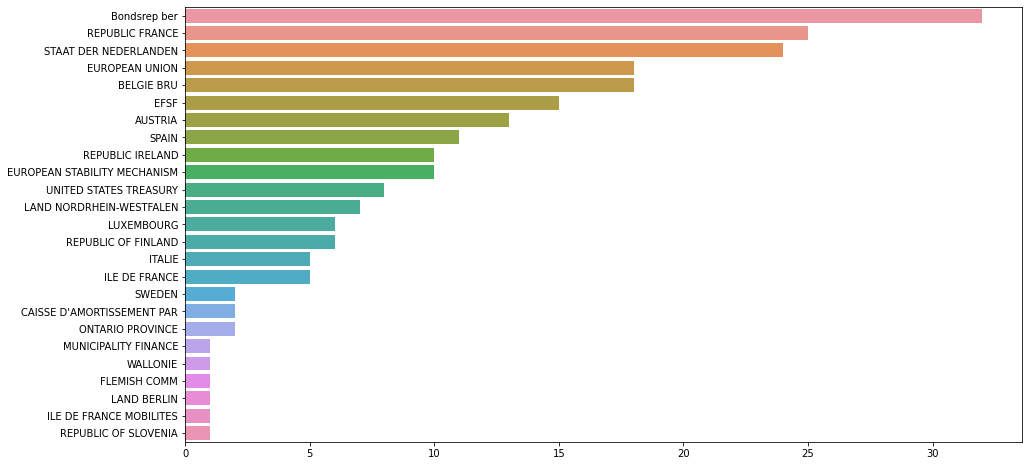

In [3]:
plt.figure(figsize=(15,8))
visualize.countplot(data = df_bonds, x = 'issuer_name')

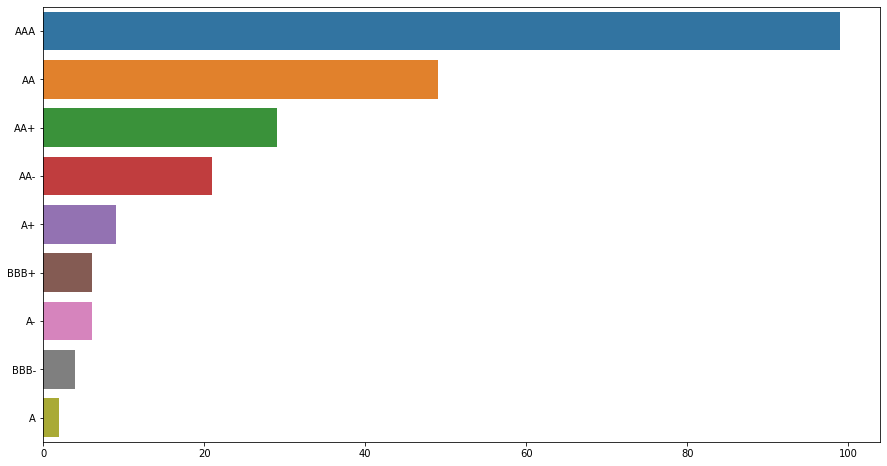

In [4]:
plt.figure(figsize=(15,8))
visualize.countplot(data = df_bonds, x = 'issue_rating')

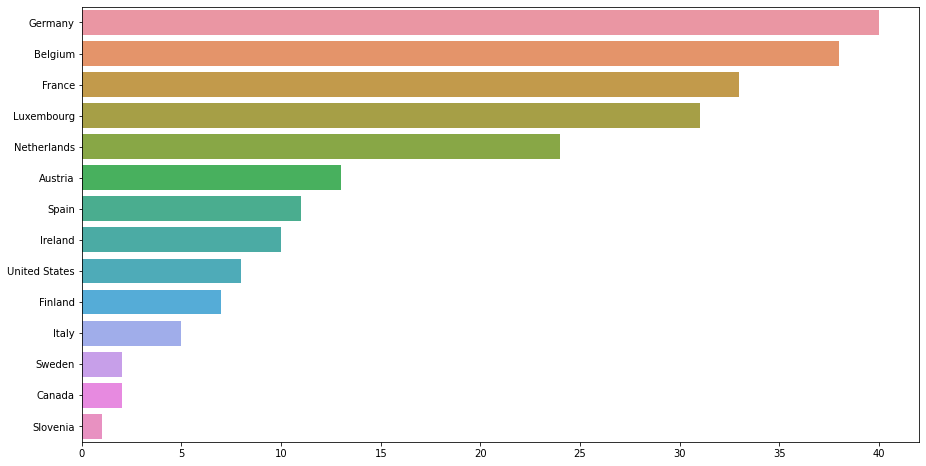

In [5]:
plt.figure(figsize=(15,8))
visualize.countplot(data = df_bonds, x = 'country')

Bond prices

In [6]:
df_price = make_dataset.read_pkl('price')

2022-01-03 14:00:26.802 | INFO     | src.data.make_dataset:read_pkl:358 - Load preprocessed price data


In [7]:
df_price.columns

Index(['reference_identifier', 'ccy', 'rate_dt', 'mid'], dtype='object')

In [8]:
df_bonds

,ccy,country,issue_dt,first_coupon_date,mature_dt,isin,issuer_name,coupon_frq,coupon,tot_issue,cfi_code,issue_rating,bond_duration
0,EUR,Netherlands,2009-02-13,2009-07-15,2019-07-15,NL0009086115,STAAT DER NEDERLANDEN,ANNUAL,4.00000,5000000000.00000,DBFTFN,AAA,3804 days
1,NLG,Austria,1994-02-28,1995-02-28,2024-02-28,NL0000133924,AUSTRIA,ANNUAL,6.25000,1000000000.00000,DBFTXB,AA+,10957 days
2,EUR,Netherlands,2012-03-09,2013-01-15,2033-01-15,NL0010071189,STAAT DER NEDERLANDEN,ANNUAL,2.50000,4160000000.00000,DBFXXN,AAA,7617 days
3,USD,United States,2009-05-15,2009-11-15,2019-05-15,US912828KQ20,UNITED STATES TREASURY,SEMI ANNUAL,3.12500,64411000000.00000,DXXXXX,AAA,3652 days
4,USD,United States,2010-02-15,2010-08-15,2020-02-15,US912828MP29,UNITED STATES TREASURY,SEMI ANNUAL,3.62500,0.00000,DXXXXX,AAA,3652 days
...,...,...,...,...,...,...,...,...,...,...,...,...,...
220,EUR,Spain,2021-06-29,2021-10-31,2031-10-31,ES0000012I32,SPAIN,ANNUAL,0.50000,8000000000.00000,DBFTFB,A-,3776 days
221,EUR,Slovenia,2021-07-01,2021-07-01,2031-07-01,SI0002104196,REPUBLIC OF SLOVENIA,ANNUAL,0.12500,1000000000.00000,DBFTFR,A,3652 days
222,EUR,Belgium,2021-07-06,2021-07-06,2026-07-06,EU000A3KTGV8,EUROPEAN UNION,ANNUAL,0.00000,9000000000.00000,DNFCFB,AAA,1826 days
223,EUR,Belgium,2021-07-06,2021-07-06,2051-07-06,EU000A3KTGW6,EUROPEAN UNION,ANNUAL,0.70000,6000000000.00000,DNFCFB,AAA,10957 days


2022-01-03 14:00:27.311 | INFO     | src.data.make_dataset:read_pkl:358 - Load preprocessed bp data
2022-01-03 14:00:27.405 | INFO     | src.data.make_dataset:read_pkl:358 - Load preprocessed yield data


<AxesSubplot:xlabel='rate_dt', ylabel='mid'>

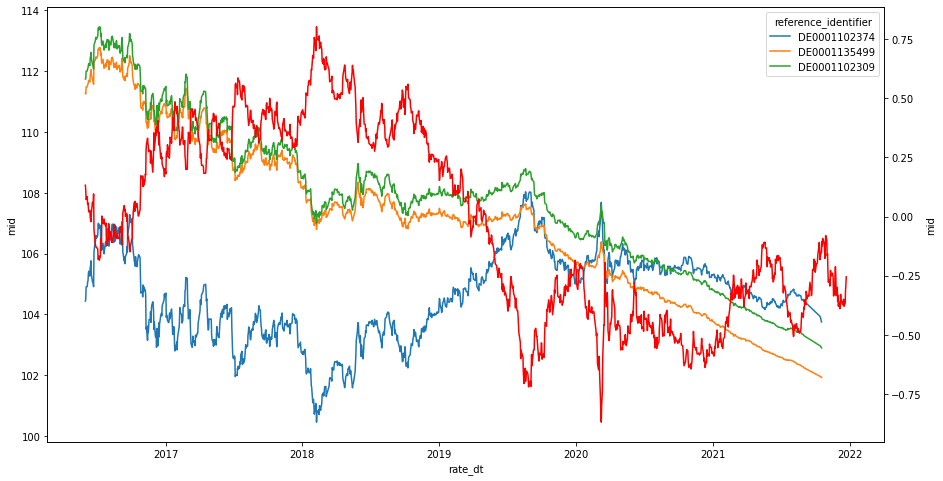

In [9]:
#df = make_dataset.join_bond_data(df_bonds,df_price,['DE0001102309','DE0001102374', 'DE0001135499']) # Example 3 German Bonds 10 Years
plt.figure(figsize=(15,8))

df_bp = make_dataset.read_pkl('bp')

df_yield = make_dataset.read_pkl('yield')
df_y = df_yield[(df_yield['country']=='Germany') & (df_yield['timeband']=='10 YEARS')].copy()


df = df_bp[df_bp['isin'].isin(['DE0001102309','DE0001102374', 'DE0001135499'])]
df = df[df['rate_dt'] >= df_y['rate_dt'].min()]
sns.lineplot(data = df, x = 'rate_dt', y = 'mid', hue = 'reference_identifier')

df_y['mid'] = (df_y['bid'] + df_y['offer'] ) / 2
df_y = df_y[df_y['rate_dt'] >= df['rate_dt'].min()]

ax2 = plt.twinx()
sns.lineplot(data = df_y, x = 'rate_dt', y = 'mid', color = 'red', ax=ax2)


In [10]:
df_yield['mid'] = (df_yield['bid'] + df_yield['offer'] ) /2

<AxesSubplot:xlabel='days', ylabel='mid'>

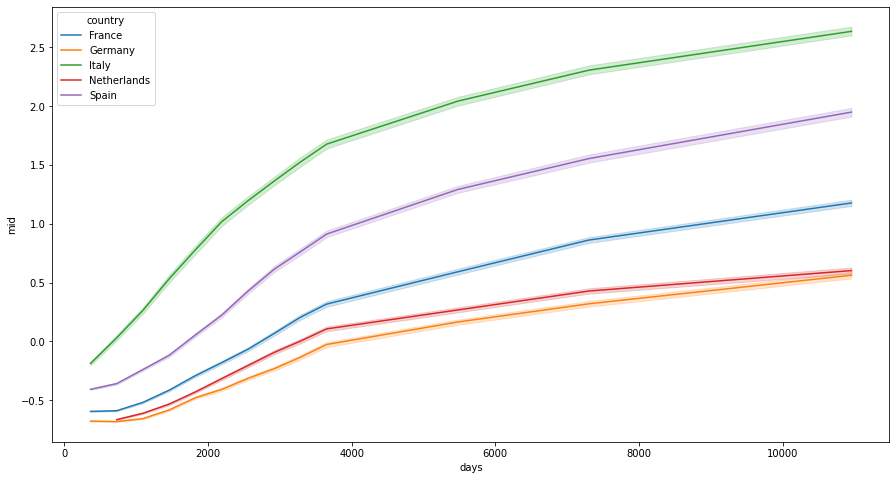

In [11]:
plt.figure(figsize=(15,8))
df_yield['days'] = df_yield['time'].dt.days
sns.lineplot(data = df_yield, x = 'days', y ='mid', hue = 'country')

<AxesSubplot:xlabel='rate_dt', ylabel='mid'>

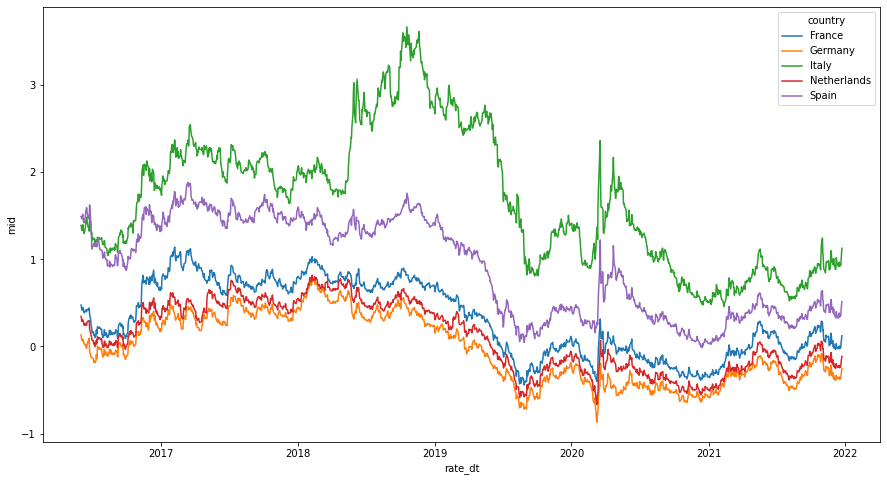

In [22]:
df_yield_10y = df_yield[df_yield['timeband'] == '10 YEARS']
plt.figure(figsize=(15,8))
sns.lineplot(data = df_yield_10y, x = 'rate_dt', y ='mid',hue = 'country')

<AxesSubplot:xlabel='rate_dt', ylabel='mid'>

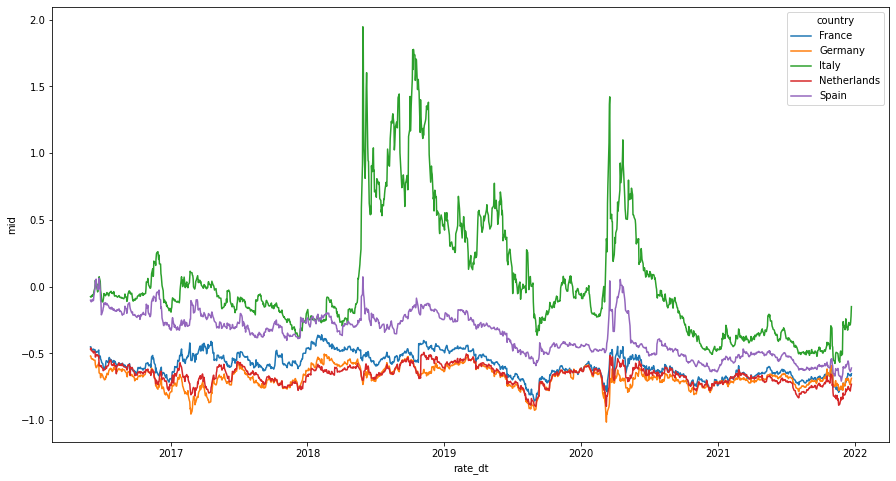

In [23]:
df_yield_2y = df_yield[df_yield['timeband'] == '2 YEARS']
plt.figure(figsize=(15,8))
sns.lineplot(data = df_yield_2y, x = 'rate_dt', y ='mid',hue = 'country')

In [ ]:
df_bpy =  make_dataset.read_pkl('bpy')

In [ ]:
df_bpy = df_bpy[df_bpy['reference_identifier'].isin(['DE0001102309','DE0001102374', 'DE0001135499'])]
sns.lineplot(data = df_bpy, x = 'rate_dt', y ='mid', hue = 'timeband')


In [ ]:
df_m.columns

In [ ]:
df_yield = make_dataset.read_pkl('yield')

In [ ]:
df_yield

In [ ]:
df_yield[(df_yield['timeband'] == '10 YEARS') & (df_yield['country']=='Germany') ] 

In [ ]:
df_de = df_yield.query('country == "Germany" & timeband.strip == "10 YEARS"')





In [ ]:
df_de

In [ ]:
df.head()

In [ ]:
from src.features import build_features
df = build_features.add_duration(df)




In [ ]:
df

Government Yield

In [ ]:
df_yield = make_dataset.read_pkl('yield')

In [ ]:
visualize.countplot(data = df_yield, x = 'country')

Credit Spread

Term Spread

Inflation

In [ ]:
df_inflation = make_dataset.read_pkl('inflation')

Inflation should be negatively correlated to the bond price